# Net Primary Productivity (NPP) + Polynyas
- Plot Growth season (ONDJFM) integrated NPP from CESM2-LE and location of polynyas
- 2000, 2090, and difference (2090 - 2000)
- Needs to load CESM timeseries
- Notebook by Alice DuVivier (NCAR)
- July 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

## Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Read in SIZ data

In [6]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

In [7]:
# load SIZ
file_in = 'CESM2-LE-SIZ.nc'
ds_siz = xr.open_dataset(path_in+file_in, decode_times=True)

In [8]:
data_siz = ds_siz.SIZ_SEP

### Calculate means for 2000s and 2090s and make mask

In [9]:
#  make temporary array with only ones for masks
mask_ones = np.ones([len(ds_siz.TLAT.nlat),len(ds_siz.TLAT.nlon)])
mask_ones = xr.DataArray(mask_ones,dims=('nlat','nlon'))
mask_ones['nlat'] = ds_siz.TLAT.nlat
mask_ones['nlon'] = ds_siz.TLAT.nlon

In [10]:
# use a threshold of 0.5 for SIZ zone. More than 50% of the time a point is in the SIZ if this is >= 0.5
thresh = 0.5

In [11]:
# choose decade
dec = 2000

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = data_siz.isel(time=data_siz.time.isin([yy]))
# take mean over those years and all ensemble members
temp = temp.mean(dim=['time','member_id'])
# make mask of ones where it's in the SIZ and 0 everywhere else
siz_2000 = mask_ones.where(temp >= thresh)

In [12]:
# choose decade
dec = 2090

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = data_siz.isel(time=data_siz.time.isin([yy]))
# take mean over those years and all ensemble members
temp = temp.mean(dim=['time','member_id'])
# make mask of ones where it's in the SIZ and 0 everywhere else
siz_2090 = mask_ones.where(temp >= thresh)

## Read in MARBL data

### Load the CESM2-LE MARBL data and mask by SIZ

In [13]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [14]:
# load variable
file_in = 'CESM2-LE-seasonal-integrals-NPP.nc'
ds_in = xr.open_dataset(path_in+file_in, decode_times=True)

units = ds_in.NPP_ONDJFM.units

In [15]:
# use entire growth season
data = ds_in.NPP_ONDJFM

In [16]:
# mask points in the SIZ by year and member
data_mask = data.where(data_siz == 1)

### Calculate means and differences for 2000s and 2090s

In [17]:
# choose decade
dec = 2000

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = data_mask.isel(time=data_mask.time.isin([yy]))
# take mean over those years and all ensemble members
temp = temp.mean(dim=['time','member_id'])
# replace missing values with 0 for NPP
data_mean_2000 = temp.fillna(0)

In [18]:
# choose decade
dec = 2090

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = data_mask.isel(time=data_mask.time.isin([yy]))
# take mean over those years and all ensemble members
temp = temp.mean(dim=['time','member_id'])
# replace missing values with 0 for NPP
data_mean_2090 = temp.fillna(0)

In [19]:
# calculate absolute and percent differences from 2000s
diff_abs = data_mean_2090 - data_mean_2000

# calculate percent difference
#diff_pct = 100.0* (diff_abs/data_mean_2000)
top = data_mean_2090 - data_mean_2000
bot = (data_mean_2090 + data_mean_2000)/2.0
diff_pct = 100.0 * abs(top/bot)

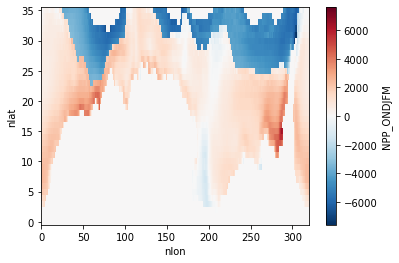

In [20]:
diff_abs.plot()

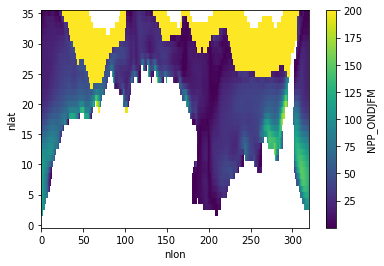

In [21]:
# mask some super high pct diffs
diff_pct.where(abs(diff_pct) <=1000).plot()

In [22]:
# mask the percent differences by where the difference is >10% (for stippling)
diff_pct_10 = mask_ones.where(abs(diff_pct) <= 10.0)

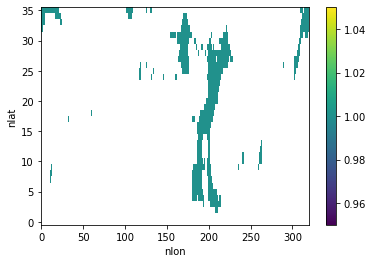

In [23]:
diff_pct_10.plot()

## Load Typical polynya data

In [24]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

In [25]:
# Read in cesm2-le polynya data
file_in = 'CESM_grid_CESM2-LE_typical_polynya.nc'
ds_poly = xr.open_mfdataset(path_in+file_in,decode_times=False)

poly_cesm2le_pd = ds_poly.polynya_typical_all_hi

# keep some decades
poly_2000 = poly_cesm2le_pd.sel(decades=2000)
poly_2090 = poly_cesm2le_pd.sel(decades=2090)

## Load regional mask data and shapefiles

In [26]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [27]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


In [28]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Plot figures

In [29]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [30]:
# get colony distance info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

In [31]:
# make arrays for the Amundsen/Peninsula region
lats_bound = np.arange(-73, -50, 1)
#lats_bound
lons_bound = np.linspace(275, 275, lats_bound.shape[0])
#lons_bound

In [32]:
# mask to omit land points
data_mean_2000 = data_mean_2000.where(ds_grid.REGION_MASK == 1)
data_mean_2090 = data_mean_2090.where(ds_grid.REGION_MASK == 1)
diff_abs = diff_abs.where(ds_grid.REGION_MASK == 1)
diff_pct = diff_pct.where(ds_grid.REGION_MASK == 1)
diff_pct_10 = diff_pct_10.where(ds_grid.REGION_MASK == 1)

In [33]:
# mask outside of average decadal SIZ zone
data_mean_2000 = data_mean_2000.where(siz_2000 >0)
data_mean_2090 = data_mean_2090.where(siz_2090 >0)
diff_abs = diff_abs.where(siz_2090 >0)
diff_pct = diff_pct.where(siz_2090 >0)
diff_pct_10 = diff_pct_10.where(siz_2090 >0)

In [34]:
# divide the data by 1000 to get better plotting
data_mean_2000 = data_mean_2000/1000.0
data_mean_2090 = data_mean_2090/1000.0
diff_abs = diff_abs/1000.0

### Set plotting ranges, etc.

In [35]:
print('maximum value for 2000')
print(data_mean_2000.max(dim=['nlat','nlon']).values)
print('maximum value for 2090')
print(data_mean_2090.max(dim=['nlat','nlon']).values)

maximum value for 2000
14.313802494995118
maximum value for 2090
14.457809900390625


In [36]:
# set some plotting info
cmap_in = cmocean.cm.algae
vmin_in = 0.0
vmax_in = 10.0
levels_in_poly = np.arange(0,3,1)
levels_in_siz = np.arange(0,3,1)
levels_in_ctr = np.arange(0,3,1)
title = 'Growing season (ONDJFM) total NPP'

In [37]:
print('maximum and minimum absolute differences in growth 2090 - 2000')
print(diff_abs.max(dim=['nlat','nlon']).values)
print(diff_abs.min(dim=['nlat','nlon']).values)

maximum and minimum absolute differences in growth 2090 - 2000
6.362036343917846
-1.5872565697523013


In [38]:
# set some plotting info
cmap_diff = cmocean.cm.balance
vmin_diff = -5.0
vmax_diff = 5.0
vmin_pct_diff = -150.0
vmax_pct_diff = 150.0

### Final Panel Plot

In [39]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'
fout = 'Figure_6_NPP_siz_polynya_2000_2090'

#labels
lab1 = 'a) NPP 2000s'
lab2 = 'b) NPP 2090s'
lab3 = 'c) NPP Difference'
sz = 20

# legend line
lats_line = np.arange(-89.0, -85.0, 1)
lons_line = np.linspace(270,270,lats_line.shape[0])

In [40]:
# print units because we have to add them manually below
units

'mmol/m2/year'

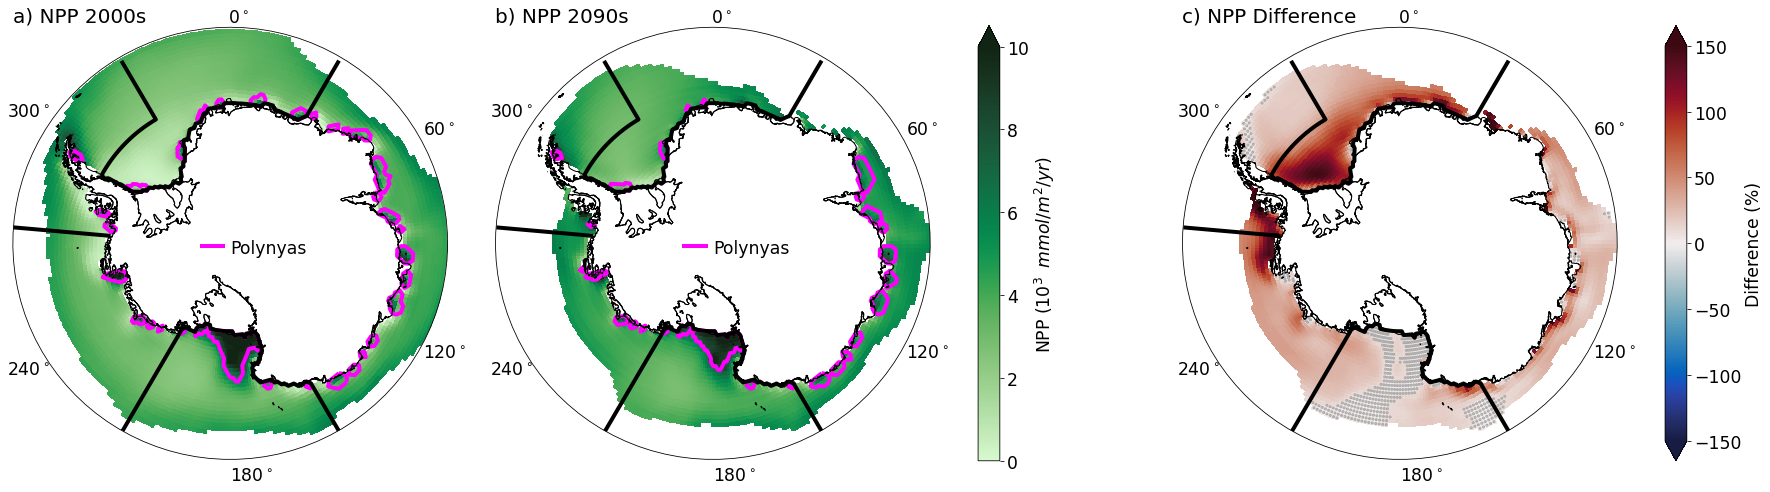

In [41]:
# Plot - percent difference (2090 - 2100)
# create figure
fig = plt.figure(figsize=(30,8))

# set plot spacing for the figure to include colorbars
gs = gridspec.GridSpec(nrows=1, ncols=6, width_ratios=(1, 1, 0.05, 0.2, 1, 0.05))

prj =ccrs.SouthPolarStereo()

# set all the different plot items
ax_map1 = plt.subplot(gs[0, 0], projection=prj)
ax_map2 = plt.subplot(gs[0, 1], projection=prj)
ax_map3 = plt.subplot(gs[0, 4], projection=prj)

ax_cb = plt.subplot(gs[0, 2])
ax_cb_diff = plt.subplot(gs[0, 5])

### Plot 1 - 2000 ###########################################################################
ax_map1.set_boundary(circle, transform=ax_map1.transAxes)
ax_map1.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax_map1.set_title(lab1,loc='left',fontsize=sz)
### Main Plot
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2000)
this=ax_map1.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
### Overlay polynyas
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2000.fillna(0))
this2=ax_map1.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=4,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree())
# add polynya legend
this2=ax_map1.plot(lons_line,lats_line, color='magenta',linestyle='solid',linewidth=4, transform=ccrs.PlateCarree())
this2=ax_map1.text(180.0,-89.0, 'Polynyas', color='black', fontsize='xx-large', transform=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax_map1.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax_map1.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax_map1.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax_map1.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax_map1.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax_map1.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax_map1.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax_map1.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax_map1.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
### Add shapefile coastlines
ax_map1.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot 2 - 2090 ###########################################################################
ax_map2.set_boundary(circle, transform=ax_map2.transAxes)
ax_map2.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax_map2.set_title(lab2,loc='left',fontsize=sz)
### Main Plot
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2090)
this=ax_map2.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
### Overlay polynyas
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2090.fillna(0))
this2=ax_map2.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=4,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 
# add polynya legend
this2=ax_map2.plot(lons_line,lats_line, color='magenta',linestyle='solid',linewidth=4, transform=ccrs.PlateCarree())
this2=ax_map2.text(180.0,-89.0, 'Polynyas', color='black', fontsize='xx-large', transform=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax_map2.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax_map2.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax_map2.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax_map2.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax_map2.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax_map2.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax_map2.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax_map2.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax_map2.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
### Add shapefile coastlines
ax_map2.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

###################################### first color bar #################################
cbar1 = fig.colorbar(this, cax=ax_cb, extend='max')
cbar1.ax.tick_params(labelsize='xx-large')
cbar1.ax.set_ylabel(r'NPP ($10^{3} \; \; mmol/m^2/yr$)',fontsize='xx-large')

### Plot 3 - Difference ###########################################################################
ax_map3.set_boundary(circle, transform=ax_map3.transAxes)
ax_map3.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax_map3.set_title(lab3,loc='left',fontsize=sz)
### Main Plot
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct)
this=ax_map3.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_diff,                      
                     vmax=vmax_pct_diff, vmin=vmin_pct_diff,
                     transform=ccrs.PlateCarree())
### Overlay dots where values are < abs(10%) different 
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct_10)
this1 = ax_map3.scatter(lon, lat,
                   field,
                   color='darkgrey', marker='o', linewidths=2,
                   transform=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax_map3.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax_map3.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax_map3.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax_map3.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax_map3.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax_map3.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax_map3.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax_map3.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax_map3.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
### Add shapefile coastlines
ax_map3.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

###################################### second color bar #################################
cbar2 = fig.colorbar(this, cax=ax_cb_diff, extend='both')
cbar2.ax.tick_params(labelsize='xx-large')
cbar2.ax.set_ylabel('Difference (%)',fontsize='xx-large')

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

### Individual Plots

In [ ]:
# Plot - 2000 mean
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2000)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('Growing Season Total NPP ('+units+')',fontsize='xx-large')

### Overlay polynyas
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=4,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 
### Overlay SIZ
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
# Plot - 2090 mean
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2090)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('Growing Season Total NPP ('+units+')',fontsize='xx-large')

### Overlay polynyas
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=4,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 
### Overlay SIZ
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
# Plot - absolute difference (2090 - 2100)
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_abs)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_diff,                      
                     vmax=vmax_diff, vmin=vmin_diff,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='both',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('Difference in Total NPP ('+units+')',fontsize='xx-large')

### Overlay polynyas
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='dotted',linewidths=4,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=4,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 
### Overlay SIZ
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='dotted',linewidths=4,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
# Plot - percent difference (2090 - 2100)
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_diff,                      
                     vmax=vmax_pct_diff, vmin=vmin_pct_diff,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='both',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('Difference (%)',fontsize='xx-large')
### Overlay dots where values are < abs(10%) different 
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct_10)
this1 = ax.scatter(lon, lat,
                   field,
                   color='darkgrey', marker='o', linewidths=2,
                   transform=ccrs.PlateCarree())
### Overlay polynyas
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='dotted',linewidths=4,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=4,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 
### Overlay SIZ
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='dotted',linewidths=4,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
# Plot - percent difference (2090 - 2100)
# create figure
fig = plt.figure(figsize=(30,10))
        
# plot as subplots - note it's nrow x ncol x index (starting upper left)

### Plot 1 - 2000
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2000)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='vertical',extend='max',fraction=0.05,pad=0.05,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_ylabel(r'NPP ($mmol/m^2/yr$)',fontsize='xx-large')

### Overlay polynyas
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=4,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
### Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
# adding coastlines without shapefile
#ax_map2.coastlines('10m',linewidth=0.5)


### Plot 2 - 2090
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2090)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='vertical',extend='max',fraction=0.05,pad=0.05,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_ylabel(r'NPP ($mmol/m^2/yr$)',fontsize='xx-large')

### Overlay polynyas
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=4,
                 levels=levels_in_poly,
                 transform=ccrs.PlateCarree())  
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
### Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot 3 - Difference
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_diff,                      
                     vmax=vmax_pct_diff, vmin=vmin_pct_diff,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='vertical',extend='both',fraction=0.05,pad=0.05,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_ylabel('Difference (%)',fontsize='xx-large')
### Overlay dots where values are < abs(10%) different 
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct_10)
this1 = ax.scatter(lon, lat,
                   field,
                   color='darkgrey', marker='o', linewidths=2,
                   transform=ccrs.PlateCarree())
### Overlay 2090s polynyas
#lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_2090.fillna(0))
#this2=ax.contour(lon,lat,field,
#                 colors='magenta',linestyles='solid',linewidths=4,
#                 levels=levels_in_poly,
#                 transform=ccrs.PlateCarree()) 
### Overlay 2090s SIZ
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='dashed',linewidths=2.5,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
### Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)